# Voxel intensities in regions of interest

This notebook demonstrates how to define, and run, a scikit-rt application for obtaining information about voxel intensity values in region of interests (ROIs).  It uses the dataset:

Peihan Li, 'SPECT_CT_data.zip', Figshare dataset (2020)<br/>
https://doi.org/10.6084/m9.figshare.12579707.v1

If not already present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` below.  The download file has a size of 1.6 GB, so download may take a while.

For more information on scikit-rt applications, see [application_demo.ipynb](https://github.com/scikit-rt/scikit-rt/blob/master/examples/notebooks/application_demo.ipynb).

In [1]:
from pathlib import Path

from skrt.core import download

# Define URL of source dataset, and local data directory.
url = 'https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip'
topdir = Path('~/data/spect_ct').expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)

## Application for obtaining voxel intensities in ROIs

The code in the next cell implements an algorithm for obtaining and saving (by pickling) a pandas Dataframe containing voxel intensities for specified ROIs.  It also defines a function for creating and configuring an application to run this algorithm.

In [2]:
'''
Application for obtaining voxel intensities in ROIs.
'''

from itertools import chain
from pathlib import Path

import pandas as pd

from skrt.application import Algorithm, Application, get_paths
from skrt.core import compress_user, tic, toc

class ROIIntensities(Algorithm):
    '''
    Algorithm subclass, for obtaining voxel intensities in ROIs.

    Methods:
        __init__ -- Return instance of ROIIntensities class,
                    with properties set according to options dictionary.
        execute  -- Obtain ROI intensities.
    '''

    def __init__(self, opts={}, name=None, log_level=None):
        '''
        **Parameters:**

        opts: dict, default={}
            Dictionary for setting algorithm attributes.

        name: str, default=''
            Name for identifying algorithm instance.

        log_level: str/int/None, default=None
            Severity level for event logging.  If the value is None,
            log_level is set to the value of skrt.core.Defaults().log_level.
        '''
        
        # Dictionary where keys are names of ROIs for which intensities
        # are to be obtained, and values are lists of names with which
        # the ROIs may be labelled.
        # If None, all ROIs in the structure sets loaded are considered.
        self.roi_names = None

        # Name of output pkl file.
        self.output_pkl = None

        # Override default properties, based on contents of opts dictionary.
        super().__init__(opts, name, log_level)
        
        # List of dictionaries containing data for voxel intensities in ROIs.
        self.roi_data = []

    def execute(self, patient):

        '''
        Obtain voxel intensities inside ROIs.

        **Parameter:**

        patient: skrt.patient.Patient/None, default=None
            Object providing access to patient dataset.
        '''
        # Print details of current patient.
        self.logger.info(f'Patient id: {patient.id}')
        self.logger.info(f'Folder path: {compress_user(patient.path)}')
        
        # Try to identify in the dataset a structure set linked to a CT image.
        for study in patient.studies:
            ct_structure_sets = getattr(study, 'ct_structure_sets', [])
            if ct_structure_sets:
                break
                        
        if ct_structure_sets:
            # Create data record for current patient, and append to list.
            rois = ct_structure_sets[0].filtered_copy(names=self.roi_names, keep_renamed_only=True)
            record = {'id': patient.id, 'study': study.get_pandas_timestamp()}
            record.update({roi.name: roi.get_intensities() for roi in rois})
            self.roi_data.append(record)
            self.logger.info(f'ROIs found: {rois.get_roi_names()}')
        else:
            self.logger.info('No structure set linked to CT image.')
                
        # Report time taken.
        # (Timer is started in Patient constructor.)
        self.logger.info(f'Processing time: {toc():.2f} seconds\n')

        return self.status

    def finalise(self):
        # Create dataframe from list of records.
        df = pd.DataFrame(self.roi_data)
        
        # Serialise dataframe.
        if self.output_pkl:
            df.to_pickle(self.output_pkl)

        return self.status


def get_app(log_level='INFO'):
    '''
    Define and configure application to be run.
    '''
    # Set options via a dictionary, where keywords are algorithm attributes,
    # and the associated values will be assigned to them
    # when the algorithm is instantiated.
    options = {}

    # Create algorithm object
    alg = ROIIntensities(opts=options, name=None, log_level=log_level)

    # Create the list of algorithms to be run (here just the one)
    algs = [alg]

    # Create the application
    app = Application(algs=algs, log_level=log_level)

    return app

## Running application

The application's run method is passed a list of paths to patient folders,
and may optionally be passes keyword-value pairs to be used internally when creating
[skrt.patient.Patient]() objects.  Paths to patient folders may be obtained using the [skrt.application.get_paths()]() function.

In [3]:
# Define and configure the application to be run.
app = get_app()

# Algorithm options may be overwritten here.
output_pkl = 'roi_intensities.pkl.gz'
app.algs[0].output_pkl = output_pkl
roi_names = {'lung_left': 'lung_l*', 'lung_right': ['lung_r*', 'r_lung'],
             'spinal_cord': '*cord*', 'heart': 'heart'}
app.algs[0].roi_names = roi_names

# Define the patient data to be analysed.
# Set max_path to an integer value to limit the number of patient folders considered.
paths = get_paths({datadir: ['0*']}, max_path=None)

# Run application for the selected data
app.run(paths, unsorted_dicom=True);

ROIIntensities - INFO - Patient id: 001
ROIIntensities - INFO - Folder path: ~/data/spect_ct/SPECT_CT_data/001
ROIIntensities - INFO - ROIs found: ['lung_left', 'lung_right', 'spinal_cord']
ROIIntensities - INFO - Processing time: 7.33 seconds

ROIIntensities - INFO - Patient id: 002
ROIIntensities - INFO - Folder path: ~/data/spect_ct/SPECT_CT_data/002
ROIIntensities - INFO - ROIs found: ['lung_left', 'lung_right', 'spinal_cord']
ROIIntensities - INFO - Processing time: 10.31 seconds

ROIIntensities - INFO - Patient id: 003
ROIIntensities - INFO - Folder path: ~/data/spect_ct/SPECT_CT_data/003
ROIIntensities - INFO - ROIs found: ['lung_left', 'lung_right', 'spinal_cord', 'heart']
ROIIntensities - INFO - Processing time: 9.80 seconds

ROIIntensities - INFO - Patient id: 004
ROIIntensities - INFO - Folder path: ~/data/spect_ct/SPECT_CT_data/004
ROIIntensities - INFO - ROIs found: ['lung_left', 'lung_right', 'spinal_cord', 'heart']
ROIIntensities - INFO - Processing time: 14.30 seconds



## Application output

The application's output may be read back to a pandas DataFrame.  A column is included for each specified ROI found for at least one patient.  Voxel intensities for a given patient and ROI are stored in a single cell, as a one-dimentional [numpy array](https://numpy.org/doc/stable/reference/generated/numpy.array.html).

In [4]:
df = pd.read_pickle(output_pkl)
print('DataFrame column headings:')
print(df.columns)
print('\nIdentifier and heart intensity values (HU) for first patient with heart outlined.')
print(df.dropna(subset=['heart']).iloc[0][['id', 'heart']])

DataFrame column headings:
Index(['id', 'study', 'lung_left', 'lung_right', 'spinal_cord', 'heart'], dtype='object')

Identifier and heart intensity values (HU) for first patient with heart outlined.
id                                                     003
heart    [-29.0, -19.0, -29.0, -38.0, -54.0, -75.0, -82...
Name: 2, dtype: object


## Visualising data

Dataframe data may be visualised using [matplotlib](https://matplotlib.org/).  The code in the next cell imports relevant modules, and sets some parameters for [matplotlib runtime configuration](https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-dynamic-rc-settings)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set paramters for matplotlib runtime configuration.
mpl.rcdefaults()
plt.style.use('seaborn-ticks')
mpl.rc('axes', grid=False, labelsize=15, xmargin=0)
mpl.rc('axes.grid', which='both')
mpl.rc('figure', figsize=(4., 3.))
mpl.rc('grid', linestyle=(0, (1, 1)))
mpl.rc('patch', edgecolor='black', linewidth=0.5)
mpl.rc('xtick', labelsize=15, top=False)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick', labelsize=15, right=False)
mpl.rc('ytick.minor', visible=True)

# Histogramming intensity values

The code in the following cell defines a function for histogramming voxel intensities in an ROI, either for all patients in the dataset or for an individual patient.

In [6]:
def plot_histogram(df, roi_name, patient_id=None, bins=77, range=(-1040, 500),
                   facecolor=(0, 0, 0, 0.2), edgecolor='black', lw=0.8, figsize=(5, 3),
                   grid=True, print_run=False, out_format='pdf'):
    '''
    Plot a histogram of voxel intensities in a region of interest (ROI).
    
    **Parameters:**
    
    df : pandas.DataFrame
        DataFrame containing ROI voxel intensities.
        
    roi_name : str
        Name of ROI for which voxel intensities are to be plotted.  The name must
        correspond to the heading of a column of the input DataFrame.
        
    patient_id : str, default=None
        Identifier of the patient for whom voxel intensities are to be plotted.  If
        None, voxel intensities are plotted, in a single histogram, for all patients
        included in the input DataFrame.
        
    bins : int, default=77
        Number of bins in the histogram.
        
    range : tuple, default=(-1040, 500)
        Two element tuple defining the minimum and maximum of the histogram range.
        
    facecolor : str/tuple, default=(0, 0, 0, 0.2)
        Histogram fill colour, specified using a format recognised by matplotlib:
        https://matplotlib.org/stable/tutorials/colors/colors.html
        
    edgecolor : 'black'
       Histogram line colour, specified using a format recognised by matplotlib:
       https://matplotlib.org/stable/tutorials/colors/colors.html
       
    lw : float, default=0.8
        Histogram line width, in points.
        
    figsize : tuple, default=(5, 3)
        Figure width and height, in inches.
        
    grid : bool, default=True
        If True, overlay a grid on the histogram.
        
    print_run : bool, default=True
        If True, save histogram figure to file.
        
    out_format : str, default=pdf
        Format of output file.
    '''
    if patient_id is None:
        # Obtain an array containing voxel intensities for a specified ROI for all patients.
        intensities = np.concatenate(df[roi_name].dropna().to_numpy())
    else:
        # Obtain an array containing voxel intensities for a specified ROI for a specified patient.
        intensities = df[df['id'] == patient_id][roi_name]
        if intensities.isna().any():
            return

    # Create histogram.
    fig, ax = plt.subplots(1, 1, figsize=figsize)   
    ax.hist(intensities, bins=bins, range=range, density=True, edgecolor=edgecolor, lw=lw, facecolor=facecolor)
 
    # Label axes.
    ax.set_xlabel('Radiodensity (HU)')
    ax.set_ylabel('Voxels per HU')
    
    # Overlay grid.
    ax.grid(visible=grid)
    
    # Define annotations and title.
    if patient_id is None:
        n = df[roi_name].count()
        txt = f'patients = {n}'
        ax.annotate(txt, xy=(0.2, 0.9), xycoords='axes fraction', size=13)
        title = roi_name
        patient_id = "all"
    else:
        title = f"{patient_id}: {roi_name}"
    ax.set_title(title)
    
    # Save histogram to file.
    if print_run:
        fig.tight_layout() 
        fig.savefig(f'{patient_id}_{roi_name}.{out_format}')

# ROI voxel intensities for all patients

The histograms that follow show voxel intensities inside each of the ROIs, for all patients combined.

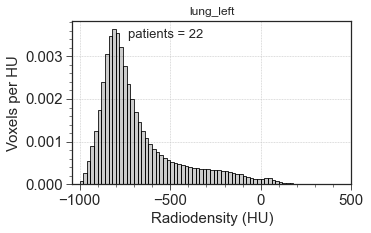

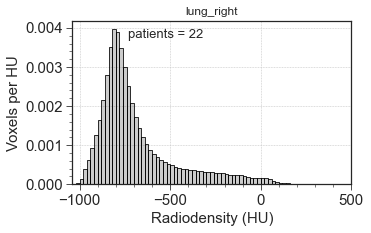

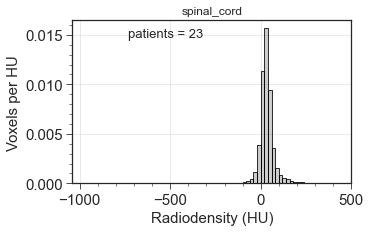

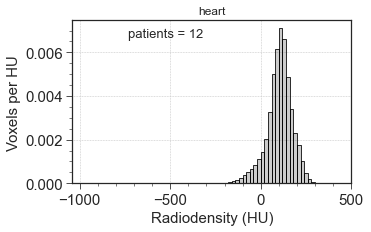

In [7]:
# Plot histogram for each ROI.
for roi_name in roi_names:
    plot_histogram(df, roi_name)

# ROI voxel intensities for individual patients

The histograms that follow show voxel intensities for a specific ROI, for each patient separately.

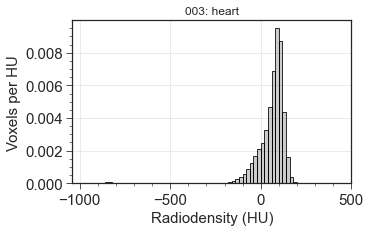

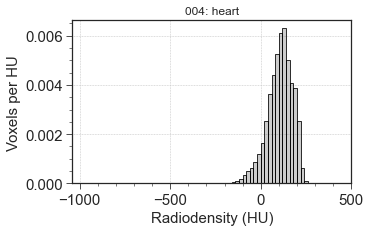

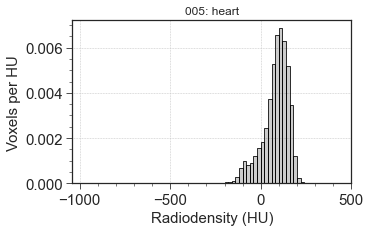

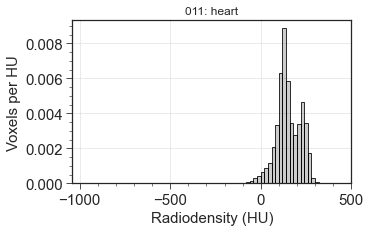

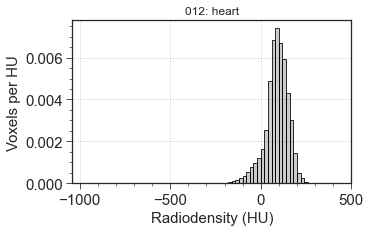

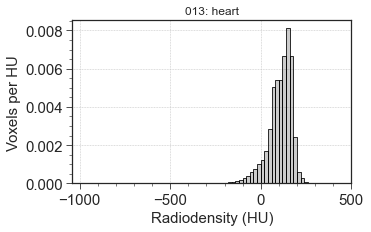

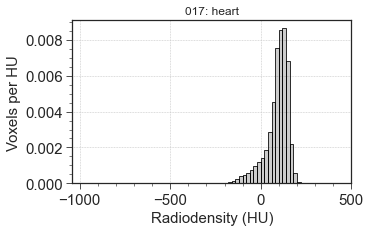

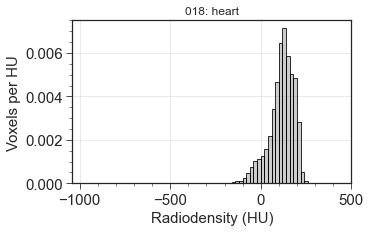

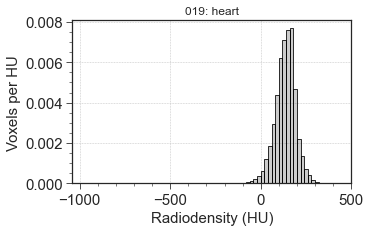

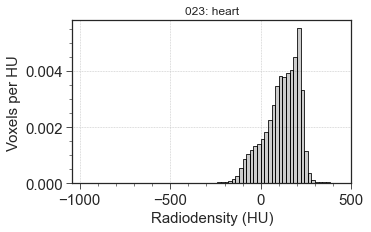

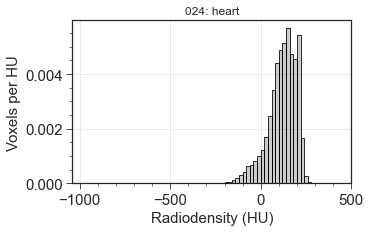

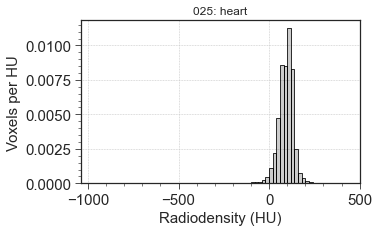

In [8]:
# Plot voxel intensities inside the named ROI for each patient separately.
roi_name = "heart"
for patient_id in df.id:
    plot_histogram(df, roi_name, patient_id)

# Viewing CT image and ROI outline

A CT image, with ROI outline superimposed, can be viewed for comparison with the histogram of voxel intensities.

In [9]:
from skrt import Patient

# Specify path to patient dataset.
patient_id = '011'
path = Path(paths[0]).parent / patient_id

# Load the dataset, and identify the structure set linked to the CT image.
patient = Patient(path, unsorted_dicom=True)
rois = patient.combined_objs('ct_structure_sets')[0]

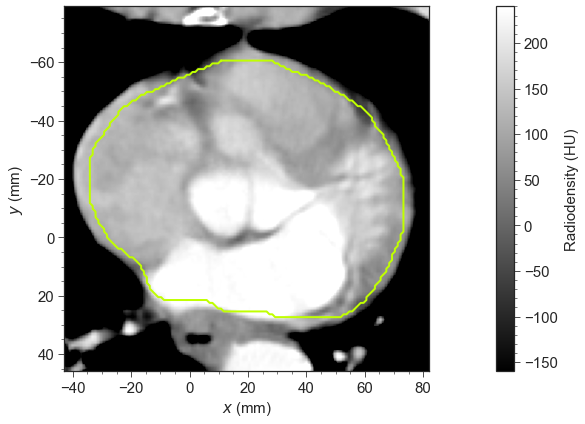

In [10]:
# Set no_ui to False to enable widgets for interactive viewing.
no_ui = True

# Display image, with ROI superimposed.
rois.image.view(rois=rois["heart"], init_pos=-91, init_roi="heart", zoom=4, colorbar=True, no_ui=no_ui);